## Analysis of Long-Term vs Short-Term Correlation Variation as an Investment Strategy

### 1. Introduction

The correlation between stock market and macroeconomic indicators is used to predict and evaluate the potential profits in an investment, looking for patterns in the financial markets that can explain and better estimate an expected profitable operation.

The Dow Jones Industrial Average (DJIA) is one of the main stock market indicators in the world, and is used to evaluate market movements and performance.

The index is compounded by 30 stocks that are selected by The Wall Street Journal editors and each company is weighted based on the price of its stock. There are index funds linked to the DJIA that try to emulate its weights and performance, but you cannot invest directly in DJIA.

Being one of the most common stock market indicators of the United States, and also being compounded by 30 of the largest and most important companies of the country, it is plausible to try to link DJIA and/or its stocks and the United States economic indicators and evaluate the correlation between them.

The objective of this analysis is to identify if the long-term correlation between macroeconomic variables and highly visible stocks (such as DJIA listed) can be compared with the short-term correlation of the same variables, looking for gaps in the correlation trend that can be an indication of an investment opportunity.

The study will focus on Business Confidence Index (BCI) and Employment Rate (EMP) as the macroeconomic indicators.

On the financial markets side of the correlation study, we will observe the SPDR DIA (Dow Jones® Industrial Average ETF Trust) and the highest weighted stock in the Dow Jones Index.

#### 1.1 Datasets Used
- Dow Jones List of Companies and Weighting (updated daily - Web Scrapping)
- Stock Market Monthly Time Series (updated monthly - API)
- US Market Confidence
- US Employability Index

#### 1.2 Research Questions
- Is there a correlation between key DJIA stocks and economic indicators?
- Are there correlation variances when we compare short-term and long-term analysis? If yes, is it possible to understand which variable is mainly responsible for the variation?
- If there are correlation variances comparing short-term vs long-term, can we use slope adjustment to identify expected stock performance?

#### 1.3 Importing Packages

In [1]:
import pandas as pd # library for data analysis
from bs4 import BeautifulSoup # library to parse HTML documents
import requests as rq
import json
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from datetime import date
from dateutil.relativedelta import relativedelta

from functools import reduce

import scipy

from scipy.stats import linregress

import warnings
warnings.filterwarnings("ignore")

#### 1.4 Create functions for use during analysis

In [2]:
#Function to import csv file extracted from OECD website
def df_oecd(path):
    ts_oecd=pd.read_csv(path)
    ts_oecd['Date']=ts_oecd['TIME']+'-01'
    ts_oecd['Date']=pd.to_datetime(ts_oecd['Date'])
    ts_oecd = ts_oecd[ts_oecd["LOCATION"] == 'USA']
    ts_oecd.sort_values(by=['Date'])
    ts_oecd.head()
    
    return ts_oecd;

#Function to import data from Alphavantage website based on DJIA Rank position (API)
def df_rank(rank):
    function='TIME_SERIES_MONTHLY'
    symbol=symb_list[rank]
    output_size='compact'
    data_type='json'
    api_key='M4HRU5SZA3C6D3MW'

    base_url = "https://www.alphavantage.co/query?"
    params = {"function":function, "symbol":symbol, "outputsize":output_size, "datatype":data_type, "apikey":api_key}

    response = rq.get(base_url, params=params)
    r=rq.get(base_url,params=params)
    data=r.json()

    ts = data.get("Monthly Time Series")
    ts=pd.DataFrame(ts)
    ts=ts.T
    ts['Symbol']=symbol
    ts['Date']=ts.index
    ts=ts.reset_index(drop=True)
    ts['Date']=ts['Date'].str[:4]+'-'+ts['Date'].str[5:7]
    ts['Date']=pd.to_datetime(ts['Date'])
    
    return ts;

#Function to import data from Alphavantage website based on stock Symbol
def df_symbol(symbol):

    function='TIME_SERIES_MONTHLY'
    symbol=symbol
    output_size='compact'
    data_type='json'
    api_key='M4HRU5SZA3C6D3MW'

    base_url = "https://www.alphavantage.co/query?"
    params = {"function":function, "symbol":symbol, "outputsize":output_size, "datatype":data_type, "apikey":api_key}

    response = rq.get(base_url, params=params)
    r=rq.get(base_url,params=params)
    data=r.json()

    ts_symb = data.get("Monthly Time Series")
    ts_symb=pd.DataFrame(ts_symb)
    ts_symb=ts_symb.T
    ts_symb['Symbol']=symbol
    ts_symb['Date']=ts_symb.index
    ts_symb=ts_symb.reset_index(drop=True)
    ts_symb['Date']=ts_symb['Date'].str[:4]+'-'+ts_symb['Date'].str[5:7]
    ts_symb['Date']=pd.to_datetime(ts_symb['Date'])
    ts_symb.columns = ['Open','High','Low','Close','Volume','Symbol','Date']

    return ts_symb

#Function to calculate and compare the correlation in different periods
def correl_index(index1,index2):
    long=scipy.stats.pearsonr(final_df[index1], final_df[index2])
    medium=scipy.stats.pearsonr(df_medium[index1], df_medium[index2])
    short=scipy.stats.pearsonr(df_short[index1], df_short[index2])
    
    return print("LT: "+str(round(long[0],2))+" MT: "+str(round(medium[0],2))+" ST: "+str(round(short[0],2)))

#Function to show correlation plot
def corr_plot(a,b):
     
    dfreg=final_df[[a,b]]
    dfreg=dfreg.dropna()
    dfstats=scipy.stats.pearsonr(dfreg[a], dfreg[b])
    g4=sns.jointplot(data=dfreg,x=a,y=b,kind="reg")
    g4.ax_joint.set_xlabel(a)
    g4.ax_joint.set_ylabel(b)

    plt.text(10,500,"pearsonr: "+str(round(dfstats[0],3)),fontsize=14)
    plt.text(10,440,"p-value: "+str(dfstats[1]),fontsize=14)

    plt.subplots_adjust(top=0.9)
    plt.suptitle(str(a)+" vs "+str(b),fontsize=16)
   
    return plt.show()

#### 1.5 Import Datasets

##### 1.5.1 DJIA Ranking - Wikipedia Daily Update

In [3]:
# Data collection using Web-Scrapping method
wiki="https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#:~:text=The%20Dow%20Jones%20Industrial%20Average,exchanges%20in%20the%20United%20States."
table_class="mediawiki ltr sitedir-ltr mw-hide-empty-elt ns-0 ns-subject mw-editable page-Dow_Jones_Industrial_Average rootpage-Dow_Jones_Industrial_Average skin-vector action-view skin-vector-legacy"
response=rq.get(wiki)

#  Use BeautifulSoup to read html
soup = BeautifulSoup(response.text, 'html.parser')
dowtable=soup.find('table',{'class':"wikitable"})
wiki=pd.read_html(str(dowtable))

# Convert List to Dataframe and adapt data to fit the analysis needs
dj=pd.DataFrame(wiki[0])
dj['Weight'] = dj['Index weighting'].str.rstrip("%").astype(float)/100
dj['Rank'] = dj['Weight'].rank(ascending=False)
dj.sort_values(by=['Weight'])
dj_rank=dj.sort_values(by=['Rank'])
dj_rank = dj_rank.reset_index(drop=True)
dj_rank['Date']=dj_rank['Date added'].str[:4]+'-'+dj_rank['Date added'].str[5:7]+'-01'
dj_rank['Date']=pd.to_datetime(dj_rank['Date'])
symb_list = dj_rank.Symbol.values.tolist()
dj_rank.head(2)

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting,Weight,Rank,Date
0,UnitedHealth,NYSE,UNH,Managed health care,2012-09-24,NaN,10.14%,0.1014,1.0,2012-09-01
1,Goldman Sachs,NYSE,GS,Financial services,2013-09-20,NaN,6.22%,0.0622,2.0,2013-09-01


##### 1.5.2 Stock Time Series - Data Import Function

In [4]:
# Create df for lowest weighted DJIA stock
ts_rank30=df_rank(29)
ts_rank30.head(2)

,1. open,2. high,3. low,4. close,5. volume,Symbol,Date
0,43.9000,43.9900,42.7900,43.2600,4689993,WBA,2022-06-01
1,42.6300,45.2950,39.7150,43.8300,158871965,WBA,2022-05-01


In [5]:
# Create df for DIA (DJIA index fund)
ts_dia=df_symbol('DIA')
ts_dia.head(2)

,Open,High,Low,Close,Volume,Symbol,Date
0,332.4100,332.9500,326.1000,328.3600,3715609,DIA,2022-06-01
1,330.3500,341.1700,306.2800,330.2000,125388059,DIA,2022-05-01


In [11]:
# Create df for heighest weighted DJIA stock
ts_rank1=df_rank(0)
ts_rank1.head(2)

,1. open,2. high,3. low,4. close,5. volume,Symbol,Date
0,498.3200,501.3800,487.7800,492.5500,1765587,UNH,2022-06-01
1,510.8100,513.5100,463.3300,496.7800,67952080,UNH,2022-05-01


In [12]:
#Create dataframes from OECD stats (csv)
bci=r"C:\Users\eduar\OneDrive\LT_STInvest\BCI_US.csv";
ts_bci=df_oecd(bci)

emp=r"C:\Users\eduar\OneDrive\LT_STInvest\EMP_US.csv";
ts_emp=df_oecd(emp)

In [13]:
#Merge all dataframes created using Date as join key

dfs = [ts_bci, ts_emp, ts_dia, ts_rank1, ts_rank30]
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],how='inner'), dfs)

In [15]:
#Select relevant columns for analysis, creating a complete dataset with all information used on this analysis

final_df=final_df[['Date','Value_x','Value_y','Open','High','Low','Close','Volume','1. open_x','2. high_x','3. low_x','4. close_x','5. volume_x','1. open_y','4. close_y','5. volume_y']]
final_df.columns=['Date','BCI','EMP','DIA_Open','DIA_High','DIA_Low','DIA_Close','DIA_Volume','First_Open','First_High','First_Low','First_Close','First_Volume','Last_Open','Last_Close','Last_Vol']
final_df['Year']=pd.DatetimeIndex(final_df['Date']).year


#Convert all columns to float
cols = ['DIA_Open','DIA_High','DIA_Low','DIA_Close','DIA_Volume','First_Open','First_Close','First_Volume','Last_Open','Last_Close','Last_Vol']
final_df[cols] = final_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
final_df.head(2)

,Date,BCI,EMP,DIA_Open,DIA_High,DIA_Low,DIA_Close,DIA_Volume,First_Open,First_High,First_Low,First_Close,First_Volume,Last_Open,Last_Close,Last_Vol,Year
0,2008-01-01,99.08396,71.67984,132.47,132.67,115.80,126.00,473724100.0,57.19,57.8600,48.1200,50.84,191989500.0,37.99,35.04,201483400.0,2008
1,2008-02-01,98.98666,71.43710,126.49,127.61,120.76,123.01,279035500.0,50.36,51.0300,44.0000,46.48,156703700.0,34.95,36.51,120248100.0,2008


##### Variables Index
BCI - Business Confidence Index<br>
EMP - Employment Rate<br>
DIA - SPDR Dow Jones Industrial Average ETF Trust<br>
First - Heighest Ranked DJIA Stock based on Weight<br>
Last - Lowest Ranked DJIA Stock based on Weight<br><br>

Open - Stock Price Start of the month<br>
High - Highest Stock Price during the month<br>
Low - Lowest Stock Price during the month<br>
Close - Stock Price End of the month<br>
Volume - Volume traded during the month

#### 1.6 Data Cleaning/ Manipulation

#### 1.6.1 Identify Outliers

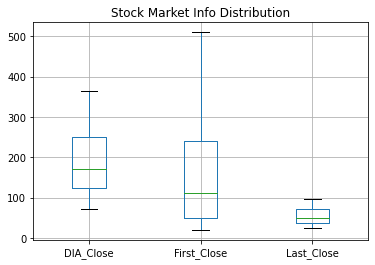

In [16]:
boxplot = final_df.boxplot(column=[ 'DIA_Close','First_Close','Last_Close'])
plt.title("Stock Market Info Distribution");

##### Even though there are high variances between minimums and maximums, especially when observing the 'First_Close' variable, there is no indication that this needs to be treated as data errors.

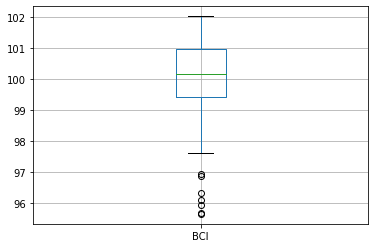

In [17]:
ax=final_df.boxplot(column=['BCI'])


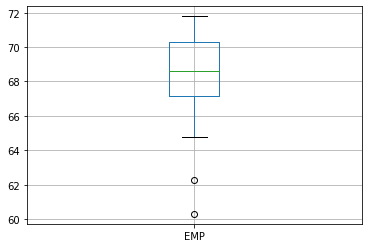

In [18]:
ax2=final_df.boxplot(column=['EMP']) 

empout=final_df[final_df['EMP']<64]
empout

##### The two Employment Rates outliers identified above are right after the start of the Covid-19 Pandemic, so these are expected values and will not be excluded from the dataset.

#### 1.6.2 Identify Null Values

#### Count amount of null values in the dataframe to identify potential data errors

In [19]:
final_df.isnull().sum().sum()

0

There are no null values in the dataframe that require attention or manipulation.<br>
The datasets used in this analysis are of common use and probably are cleaned and manipulated before publishment.

#### 1.6.3 Data Cleaning and Manipulation (function embeded)

 The functions created to import datasets are including the steps necessary to adapt the dataset to this analysis needs. 
- Add first day of the month to all dates to standardize the datasets and enable the join to work correctly.
- Extract 4 left characters of Date to identify Year and mid 5-7 characters to identify month, then convert it to date.

### 2. Data Visualization

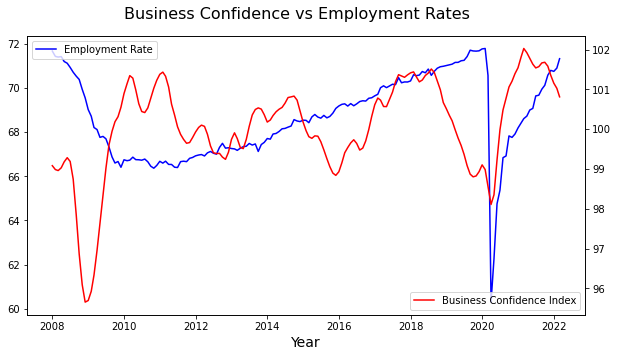

In [20]:
fig,ax = plt.subplots()

plt.subplots_adjust(top=0.9)
plt.suptitle('Business Confidence vs Employment Rates', fontsize = 16)

fig.set_size_inches(10,5, forward=True)
# make a plot
ax.plot(final_df['Date'], final_df['EMP'], "-b", label="Employment Rate")
# set x-axis label
ax.set_xlabel("Year",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(final_df['Date'], final_df['BCI'], "-r", label="Business Confidence Index")

ax.legend(loc="upper left")
ax2.legend(loc="lower right");


#### First we are exploring the movements in Business Confidence Level and the Employment Rates
##### It is possible to see that in 2009 there was a quick drop in BCI followed by a decrease in Employment rates, and the same happening in 2020, with major changes in both BCI and Employment Rates at the same time.

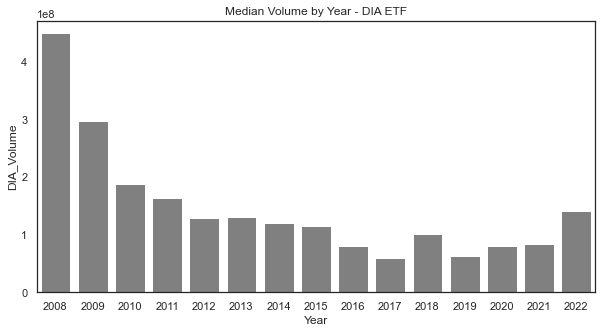

In [21]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("white")

dia_med = final_df.groupby('Year').median()
dia_med['Year']=dia_med.index
dia_med=dia_med.reset_index(drop=True)
dia_med.head()

ax1 = sns.barplot(x="Year", y="DIA_Volume", data=dia_med,color="gray").set(title='Median Volume by Year - DIA ETF')

#### After 2008, DIA median volume traded decreased year after year, but has been showing a slight increase after 2019.

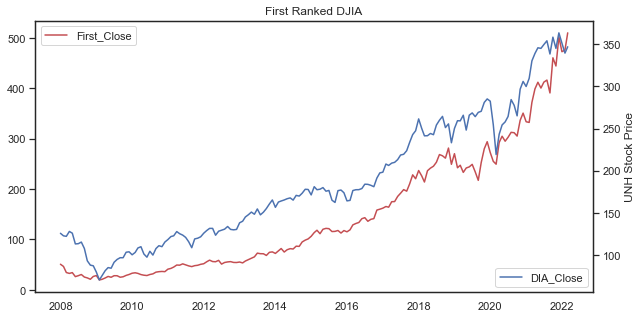

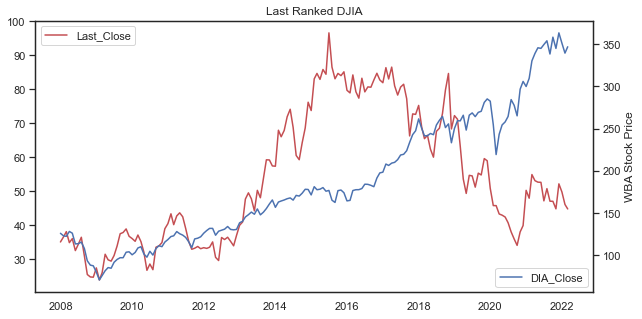

In [47]:
first=symb_list[0]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(final_df['Date'], final_df['First_Close'], color="r", label="First_Close")
ax2.plot(final_df['Date'], final_df['DIA_Close'], label="DIA_Close")
plt.title('First Ranked DJIA')
plt.xlabel('Year')
plt.ylabel(first+' Stock Price')
ax1.legend(loc="upper left")
ax2.legend(loc="lower right");


plt.show()


fig, ax1 = plt.subplots()
last=symb_list[29]
ax2 = ax1.twinx()
ax1.plot(final_df['Date'], final_df['Last_Close'], color="r", label="Last_Close")
ax2.plot(final_df['Date'], final_df['DIA_Close'], label="DIA_Close")
plt.title('Last Ranked DJIA')
plt.xlabel('Year')
plt.ylabel(last+' Stock Price')
ax1.legend(loc="upper left")
ax2.legend(loc="lower right");
plt.show()

Above we can observe that DIA and the Highest Ranked Stock in DJIA (UNH as at 31st May 2022) have similar movements overtime, while DIA and the Lowest Ranked Stock (WBA) had a high correlation between 2008 and 2013 but after this the variances increased and the correlation is lower than before.

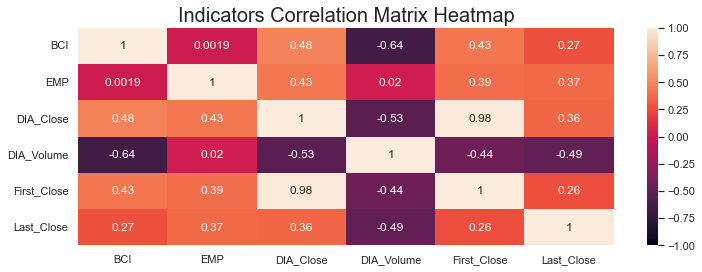

In [23]:
corr_df=final_df[['BCI','EMP','DIA_Close','DIA_Volume','First_Close','Last_Close']]
corr_df.corr()
plt.figure(figsize=(12, 4))
sns.heatmap(corr_df.corr(), vmin=-1, vmax=1, annot=True)
plt.title("Indicators Correlation Matrix Heatmap",fontsize=20);

Considering that UNH and WBA are part of the index that compound DIA, we shouldn't consider their high correlation with DIA identified for our analysis.<br>
Therefore, we should only focus on the correlation between BCI/EMP vs DIA, First Ranked (UNH) and Last Ranked (WBA) information.

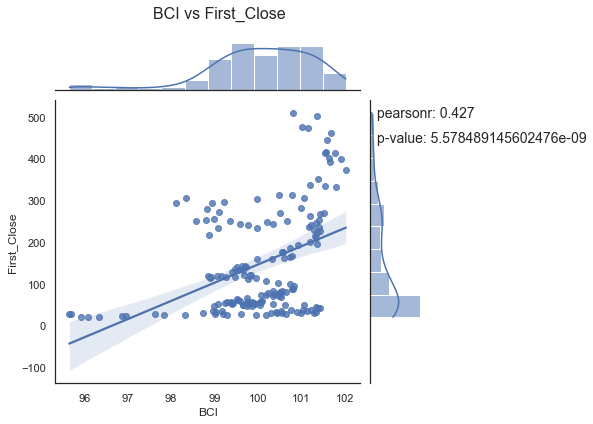

In [24]:
corr_plot('BCI','First_Close')

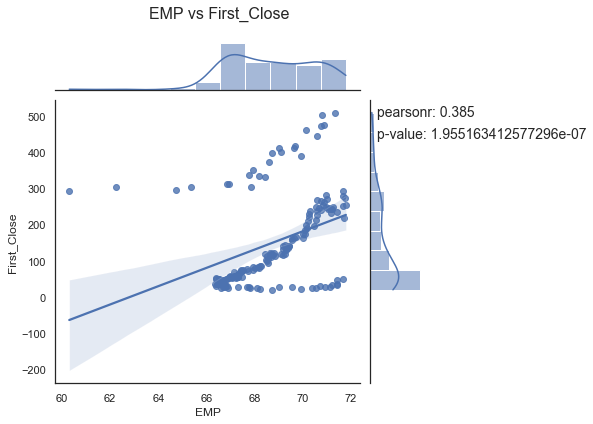

In [25]:
corr_plot('EMP','First_Close')

BCI and EMP have moderate positive correlation with First_Close and DIA_Close when analysing the entire period with data available for all instances (2008 - 2022)<br>

Is the long-term moderate correlation identified in the short-term as well?

#### Create Short-Term and Medium-Term Dataframe

In [26]:
one_year =  pd.to_datetime(date.today() + relativedelta(years=-1))
five_years =  pd.to_datetime(date.today() + relativedelta(years=-5))
df_short=final_df[final_df['Date']>one_year]
df_medium=final_df[final_df['Date']>five_years]

In [27]:
correl_index('BCI','First_Close')

LT: 0.43 MT: 0.33 ST: -0.75


We can see that there is a high variance when we compare the Long Term/ Med Term vs Short Term correlation between BCI and First_Close.<br>
There is a 0.43 pearsonr on the Long-term, while the correlation is -0.75 in the short-term.

In [28]:
a=final_df['BCI']
b=final_df['Year']
c=df_short['BCI']
d=df_short['Year']

lp_slope=linregress(a, b)[0]
st_slope=linregress(c, d)[0]

print("The long-term slope is: "+str(round(lp_slope,2)))
print("The short-term slope is: "+str(round(st_slope,2)))

The long-term slope is: 1.47
The short-term slope is: -1.47


Above we can see that there is a complete opposite direction and intensity of the short-term slope compared to the long-term slope

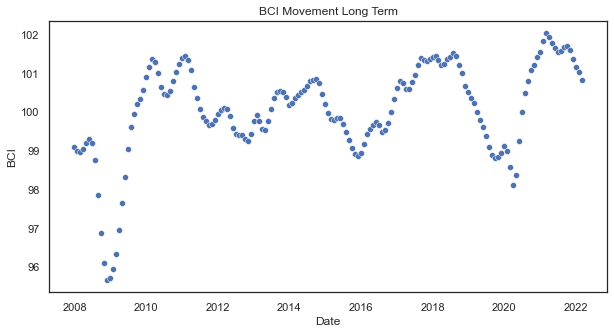

In [29]:
ax = sns.scatterplot(x="Date", y="BCI", data=final_df).set(title='BCI Movement Long Term')


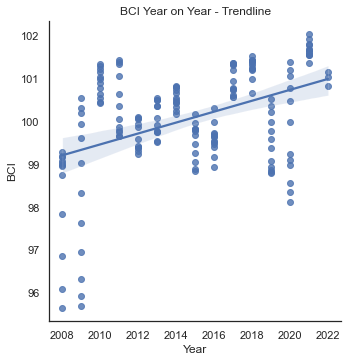

In [40]:
sns.lmplot(x="Year",
           y="BCI", 
           data=final_df).set(title='BCI Year on Year - Trendline');
plt.show()

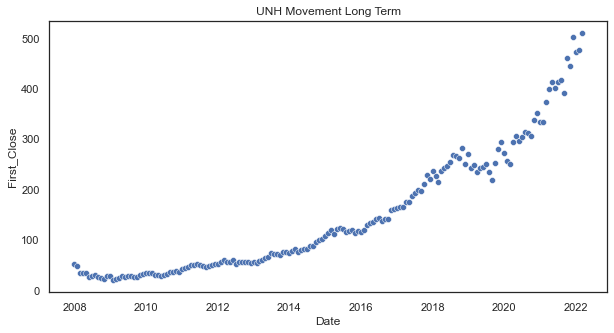

In [31]:
ax = sns.scatterplot(x="Date", y="First_Close", data=final_df).set(title='UNH Movement Long Term')


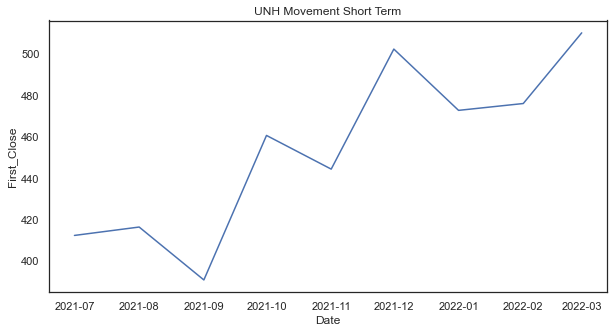

In [32]:
ax = sns.lineplot(x="Date", y="First_Close", data=df_short).set(title='UNH Movement Short Term')

In [33]:
a=final_df['First_Close']
b=final_df['Year']
c=df_short['First_Close']
d=df_short['Year']

lp_slope=linregress(a, b)[0]
st_slope=linregress(c, d)[0]
print("The long-term slope is: "+str(round(lp_slope,2)))
print("The short-term slope is: "+str(round(st_slope,2)))

The long-term slope is: 0.03
The short-term slope is: 0.01


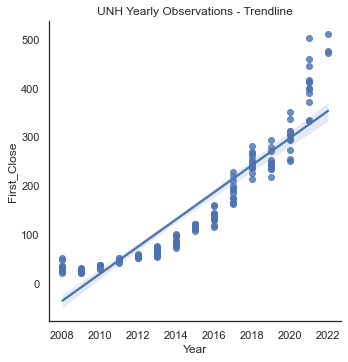

In [34]:
reg=sns.lmplot(x="Year",
           y="First_Close", 
           data=final_df).set(title='UNH Yearly Observations - Trendline');


In [35]:
correl_index('EMP','First_Close')

LT: 0.39 MT: -0.14 ST: 0.88


In [36]:
a=final_df['EMP']
b=final_df['Year']
c=df_short['EMP']
d=df_short['Year']

lp_slope=linregress(a, b)[0]
st_slope=linregress(c, d)[0]
print("The long-term slope is: "+str(round(lp_slope,2)))
print("The short-term slope is: "+str(round(st_slope,2)))

The long-term slope is: 0.75
The short-term slope is: 0.62


The hypothesis of a short-term correlation tending to an adjustment to the long-term correlation can be used as an investment strategy when we analyse independent variables, such as the Business Confidence Index and an important stock such as the heighest weighted DJIA stock.

Above, running the correlation between Economic Indicators and Stock movement for two types of periods (Long Term and Short Term) we tested if there were high variances between the two correlations found.<br>
<br> This is only an indication that we can potentially explore these variances between long vs short term correlation to trigger an investment.<br><br>
The idea is, if we identify that the short-term correlation between a stock and an economic indicator is highly different than the same pair when analysed in the long term, we have the potential of a profitable investment considering that the correlation will tend to its long term pattern.

### Testing Hypothesis - One Year

In [48]:
year=2011

#Create long-term dataframe from start to selected year
lt=final_df[final_df['Year']<=year]

#Create short-term dataframe for the selected year
st=final_df[final_df['Year']==year]

#Create dataframe for after the selected year
aft=final_df[final_df['Year']>year]

#Calculate stats for long-term, short-term and period after selected year
statlt=linregress(lt['BCI'], lt['First_Close'])[2]
statst=linregress(st['BCI'], st['First_Close'])[2]
stataft=linregress(aft['BCI'], aft['First_Close'])[2]
stockslopelt=linregress(lt['First_Close'], lt['Year'])[0]
stockslopest=linregress(st['First_Close'], st['Year'])[0]
stockslopeaft=linregress(aft['First_Close'], aft['Year'])[0]
 
print("While there is a " + str(round(statlt,2)) + " correlation between BCI and UNH in the long-term analysis, there is a "+ str(round(statst,2))+ " correlation when we observe the short-term.")

While there is a 0.5 correlation between BCI and UNH in the long-term analysis, there is a -0.61 correlation when we observe the short-term.


### Considering that the discrepancy between short and long term correlations could trigger an investment, below we evaluate the stock price movement after the selected year and also its correlation with the Business Confidence Index

In [49]:
print("BCI and UNH after the selected year have a correlation of "+str(round(stataft,2)))
print("The slope turned from "+str(round(stockslopest,2))+" in the short term to "+str(round(stockslopeaft,2))+" after the selected year")

BCI and UNH after the selected year have a correlation of 0.47
The slope turned from 0.0 in the short term to 0.02 after the selected year


#### Considering that the slope increased, there is an upward trend on the UNH after the identified year.
#### Therefore, it is possible to see that for the selected years the correlation variation between short-term and long-term succesfully triggered a potentially profitable investment.<br>
#### Just in order to evaluate the details of movements, below we can see the candlestick chart for the whole period, which includes a slidebar that zooms in/out on the periods of interest.

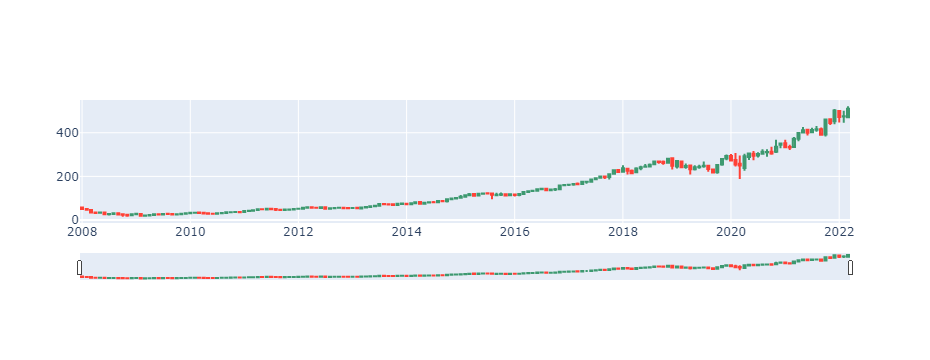

In [51]:
fig = go.Figure(data=[go.Candlestick(x=final_df['Date'],
                open=final_df['First_Open'],
                high=final_df['First_High'],
                low=final_df['First_Low'],
                close=final_df['First_Close'])])
fig.show()

### 3. Conclusion

It was possible to identify that there is a correlation between key DJIA stocks and macroeconomic indicators such as the Business Confidence Index and Employment Rates. The correlation was not strong, but moderate, and could be constantly identified if analysed in the long-term.

If we segmented the correlation calculation short vs long term, it was possible to identify high variances in the correlations, which were mostly explained by the Stock Price slope variance. This was used as a trigger to test if the slope would go back to the long-term pattern and create a potentially profitable investment scenario.

When we identify a correlation variation that can be explained by the stock price movement, it is plausible to expect that the short-term correlation will be corrected and get closer to the long-term correlation pattern, so we tested it in random years during the period that this scenario was found (Correlation variance and Stock Price Slope variance)

The results were positive and agreed with our hypothesis that the stock price slope would correct itself in the direction of the long-term correlation.

Even though the research questions were answered and, in this study, we could say that this is a strategy that has the potential of bringing profitable investment opportunities, it is understood that this analysis was an initial trigger of further and deeper studies of the efficacy and precision of the strategy. Therefore this dataset can be constantly updated with new information and moving date ranges so in the future more detailed analysis are generated.

### 4. References

Ref 1|
Ref 2|
Ref 3|
Ref 4|
Ref 5|
Ref 6|
Ref 7|

### 5. csv Extraction

In [ ]:
dj_rank.to_csv(r"C:\Users\eduar\OneDrive\LT_STInvest\djrank.csv")
ts_rank30.to_csv(r"C:\Users\eduar\OneDrive\LT_STInvest\ts_rank30.csv")
ts_dia.to_csv(r"C:\Users\eduar\OneDrive\LT_STInvest\ts_dia.csv")
ts_rank1.to_csv(r"C:\Users\eduar\OneDrive\LT_STInvest\ts_rank1.csv")
ts_bci.to_csv(r"C:\Users\eduar\OneDrive\LT_STInvest\bci.csv")
ts_emp.to_csv(r"C:\Users\eduar\OneDrive\LT_STInvest\emp.csv")